In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
#export
from nb_001b import *
import sys, PIL, matplotlib.pyplot as plt, itertools, math, random, collections, torch
import scipy.stats, scipy.special

from enum import Enum, IntEnum
from torch import tensor, Tensor, FloatTensor, LongTensor, ByteTensor, DoubleTensor, HalfTensor, ShortTensor
from operator import itemgetter, attrgetter
from numpy import cos, sin, tan, tanh, log, exp
from dataclasses import field
from functools import reduce
from collections import defaultdict, abc, namedtuple, Iterable
from typing import Tuple, Hashable, Mapping, Dict

import mimetypes
import abc
from abc import abstractmethod, abstractproperty


In [4]:
import functools

# CIFAR subset data

First we want to view our data to check if everything is how we expect it to be.

## Setup

In [5]:
DATA_PATH = Path('../data')
PATH = DATA_PATH/'cifar10_dog_air'
TRAIN_PATH = PATH/'train'

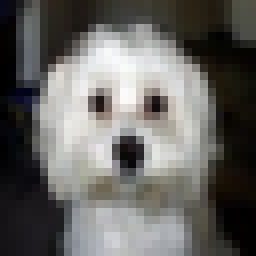

In [6]:
dog_fn = list((TRAIN_PATH/'dog').iterdir())[0]
dog_image = PIL.Image.open(dog_fn)
dog_image.resize((256,256))

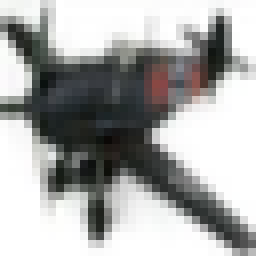

In [7]:
air_fn = list((TRAIN_PATH/'airplane').iterdir())[0]
air_image = PIL.Image.open(air_fn)
air_image.resize((256,256))

## Simple Dataset/Dataloader

We will build a Dataset class for our image files. A Dataset class needs to have two functions: length and get-item. Our FilesDataset additionally gets the image files from their respective directories and transforms them to tensors.

In [8]:
list((TRAIN_PATH).iterdir())
list((TRAIN_PATH).iterdir())[0].is_dir()

[PosixPath('../data/cifar10_dog_air/train/airplane'),
 PosixPath('../data/cifar10_dog_air/train/dog')]

True

In [9]:
#export
def image2np(image:Tensor)->np.ndarray:
    "Convert from torch style `image` to numpy/matplotlib style. Image size is (channel,h,w)"
    # convert float tensor (between 0 and 1) back to normal picture (0 to 255, height x width x channels)
    res = image.cpu().permute(1,2,0).numpy()
    return res[...,0] if res.shape[2]==1 else res

def show_image(img:Tensor, ax:plt.Axes=None, figsize:tuple=(3,3), hide_axis:bool=True, 
               title:Optional[str]=None, cmap:str='binary', alpha:Optional[float]=None)->plt.Axes:
    "Plot tensor `img` using matplotlib axis `ax`.  `figsize`,`axis`,`title`,`cmap` and `alpha` pass to `ax.imshow`"
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(image2np(img), cmap=cmap, alpha=alpha)
    if hide_axis: ax.axis('off')
    if title: ax.set_title(title)
    return ax

In [10]:
class Image():
    '''
    To include show_image function into image
    '''
    def __init__(self, px): self.px = px # type tensor
    def show(self, ax=None, **kwargs): return show_image(self.px, ax=ax, **kwargs)
    @property
    def data(self): return self.px

In [11]:
#export
FilePathList = Collection[Path]
TensorImage = Tensor
NPImage = np.ndarray

def find_classes(folder:Path)->FilePathList:
    "Return class subdirectories in imagenet style train `folder`"
    classes = [d for d in folder.iterdir()
               if d.is_dir() and not d.name.startswith('.')]
    assert(len(classes)>0)
    return sorted(classes, key=lambda d: d.name)

image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/')) # get other image type (.jpg, ...)

def get_image_files(c:Path, check_ext:bool=True)->FilePathList:
    "Return list of files in `c` that are images. `check_ext` will filter to `image_extensions`."
    return [o for o in list(c.iterdir())
            if not (o.name.startswith('.') or o.is_dir()
            or (check_ext and o.suffix not in image_extensions))]

def pil2tensor(image:NPImage)->TensorImage:
    "Convert PIL style `image` array to torch style image tensor `get_image_files`"
    arr = torch.ByteTensor(torch.ByteStorage.from_buffer(image.tobytes()))
    arr = arr.view(image.size[1], image.size[0], -1) # height x width x channels
    return arr.permute(2,0,1) # channels x height x width

PathOrStr = Union[Path,str]
def open_image(fn:PathOrStr):
    "Return `Image` object created from image in file `fn`"
    x = PIL.Image.open(fn).convert('RGB') # should return PIL.Image.Image type
    return Image(pil2tensor(x).float().div_(255)) # normalize between 0 and 1

In [12]:
image_extensions

{'.bmp',
 '.gif',
 '.ico',
 '.ief',
 '.jpe',
 '.jpeg',
 '.jpg',
 '.pbm',
 '.pgm',
 '.png',
 '.pnm',
 '.ppm',
 '.ras',
 '.rgb',
 '.svg',
 '.tif',
 '.tiff',
 '.xbm',
 '.xpm',
 '.xwd'}

In [13]:
find_classes(PATH)

[PosixPath('../data/cifar10_dog_air/test'),
 PosixPath('../data/cifar10_dog_air/train')]

In [14]:
get_image_files(TRAIN_PATH/'dog')[:5]

[PosixPath('../data/cifar10_dog_air/train/dog/28241_dog.png'),
 PosixPath('../data/cifar10_dog_air/train/dog/13112_dog.png'),
 PosixPath('../data/cifar10_dog_air/train/dog/32625_dog.png'),
 PosixPath('../data/cifar10_dog_air/train/dog/24558_dog.png'),
 PosixPath('../data/cifar10_dog_air/train/dog/8039_dog.png')]

In [15]:
path_temp=get_image_files(TRAIN_PATH/'dog')[0]
str(path_temp)

'../data/cifar10_dog_air/train/dog/28241_dog.png'

In [16]:
img_temp=open_image(path_temp)

'torch.FloatTensor'

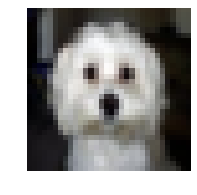

In [17]:
img_temp.data.type()
img_temp.show()

In [18]:
#export
NPArrayableList = Collection[Union[np.ndarray, list]]
NPArrayMask = np.ndarray
SplitArrayList = List[Tuple[np.ndarray,np.ndarray]]

def arrays_split(mask:NPArrayMask, *arrs:NPArrayableList)->SplitArrayList:
    "Given `arrs` is [a,b,...] and `mask`index - return[(a[mask],a[~mask]),(b[mask],b[~mask]),...]"
    mask = array(mask)
    return list(zip(*[(a[mask],a[~mask]) for a in map(np.array, arrs)]))

def random_split(valid_pct:float, *arrs:NPArrayableList)->SplitArrayList:
    "Randomly `array_split` with `valid_pct` ratio. good for creating validation set."
    is_train = np.random.uniform(size=(len(arrs[0]),)) > valid_pct
    return arrays_split(is_train, *arrs)

class DatasetBase(Dataset):
    "Base class for all fastai datasets"
    def __len__(self): return len(self.x)
    @property
    def c(self): 
        "Number of classes expressed by dataset y variable"
        return self.y.shape[-1] if len(self.y.shape)>1 else 1
    def __repr__(self): return f'{type(self).__name__} of len {len(self)}'

class LabelDataset(DatasetBase):
    "Base class for fastai datasets that do classification"
    @property
    def c(self): 
        "Number of classes expressed by dataset y variable"
        return len(self.classes)

In [19]:
??Dataset

In [20]:
#export
ImgLabel = str
ImgLabels = Collection[ImgLabel]
Classes = Collection[Any]

class FilesDataset(LabelDataset):
    "Dataset for folders of images in style {folder}/{class}/{images}"
    def __init__(self, fns:FilePathList, labels:ImgLabels, classes:Optional[Classes]=None):
        self.classes = ifnone(classes, list(set(labels)))
        self.class2idx = {v:k for k,v in enumerate(self.classes)}
        self.x = np.array(fns)
        self.y = np.array([self.class2idx[o] for o in labels], dtype=np.int64)
    
    def __getitem__(self,i): return open_image(self.x[i]),self.y[i]
    
    @staticmethod
    def _folder_files(folder:Path, label:ImgLabel, check_ext=True)->Tuple[FilePathList,ImgLabels]:
        "From `folder` return image files and labels. The labels are all `label`. `check_ext` means only image files"
        fnames = get_image_files(folder, check_ext=check_ext)
        return fnames,[label]*len(fnames)
    
    @classmethod
    def from_single_folder(cls, folder:PathOrStr, classes:Classes, check_ext=True):
        "Typically used for test set. label all images in `folder` with `classes[0]`"
        fns,labels = cls._folder_files(folder, classes[0], check_ext=check_ext)
        return cls(fns, labels, classes=classes)

    @classmethod
    def from_folder(cls, folder:Path, classes:Optional[Classes]=None, 
                    valid_pct:float=0., check_ext:bool=True) -> Union['FilesDataset', List['FilesDataset']]:
        "Dataset of `classes` labeled images in `folder`. Optional `valid_pct` split validation set."
        if classes is None: classes = [cls.name for cls in find_classes(folder)]
            
        fns,labels = [],[]
        for cl in classes:
            f,l = cls._folder_files(folder/cl, cl, check_ext=check_ext)
            fns+=f; labels+=l
            
        if valid_pct==0.: return cls(fns, labels, classes=classes)
        return [cls(*a, classes=classes) for a in random_split(valid_pct, fns, labels)]

In [21]:
train_ds = FilesDataset.from_folder(PATH/'train')
valid_ds = FilesDataset.from_folder(PATH/'test')

In [22]:
train_ds.x[:5]
train_ds.y[:5]

array([PosixPath('../data/cifar10_dog_air/train/airplane/38187_airplane.png'),
       PosixPath('../data/cifar10_dog_air/train/airplane/22304_airplane.png'),
       PosixPath('../data/cifar10_dog_air/train/airplane/11963_airplane.png'),
       PosixPath('../data/cifar10_dog_air/train/airplane/7907_airplane.png'),
       PosixPath('../data/cifar10_dog_air/train/airplane/47456_airplane.png')],
      dtype=object)

array([0, 0, 0, 0, 0])

In [23]:
train_ds.classes
train_ds.class2idx

['airplane', 'dog']

{'airplane': 0, 'dog': 1}

In [24]:
train_ds.c

2

In [25]:
train_ds[0]

(<__main__.Image at 0x7f9a88c3e390>, 0)

In [26]:
train_ds[0][0].data

tensor([[[0.9647, 0.9569, 0.9529,  ..., 0.9882, 0.9922, 0.9922],
         [0.9333, 0.9176, 0.9529,  ..., 1.0000, 1.0000, 1.0000],
         [0.6353, 0.5569, 0.7098,  ..., 1.0000, 0.9922, 0.9961],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.2431, 0.3294, 0.5255],
         [1.0000, 1.0000, 1.0000,  ..., 0.2588, 0.3137, 0.3882],
         [1.0000, 1.0000, 1.0000,  ..., 0.6706, 0.5490, 0.7255]],

        [[0.9725, 0.9647, 0.9608,  ..., 0.9843, 0.9882, 0.9922],
         [0.9412, 0.9255, 0.9608,  ..., 0.9961, 1.0000, 1.0000],
         [0.6431, 0.5647, 0.7176,  ..., 1.0000, 0.9922, 0.9961],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.2471, 0.3294, 0.5255],
         [1.0000, 1.0000, 1.0000,  ..., 0.2588, 0.3137, 0.3882],
         [1.0000, 1.0000, 1.0000,  ..., 0.6706, 0.5490, 0.7255]],

        [[0.9608, 0.9529, 0.9490,  ..., 0.9882, 0.9922, 0.9922],
         [0.9294, 0.9137, 0.9490,  ..., 1.0000, 1.0000, 1.0000],
         [0.6314, 0.5529, 0.7059,  ..., 1.0000, 0.9922, 0.

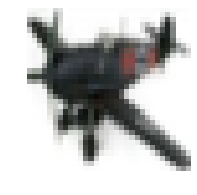

In [27]:
train_ds[0][0].show()

# Data augmentation

Now we are going augment our data to increase our training set. We will start by changing the brightness and contrast of our images.

Brightness is computed by taking the logit of the change and adding it to the logit of the images pixels. Finally we take the sigmoid of the result.

Contrast is computed by simply multiplying pixel values by the scale.

## Lighting

We will start by changing the brightness and contrast of our images.

## Method
### Brightness

Brightness refers to where does our image stand on the dark-light spectrum. Brightness is applied by adding a positive constant to each of the image's channels. This works because each of the channels in an image goes from 0 (darkest) to 255 (brightest) in a dark-light continum. (0, 0, 0) is black (total abscence of light) and (255, 255, 255) is white (pure light). You can check how this works by experimenting by yourself here.

Parameters

Change How much brightness do we want to add to (or take from) the image.

$C \in \mathbb{R}$

### Contrast

Contrast refers to how sharp a distinction there is between brighter and darker sections of our image. To increase contrast we need darker pixels to be darker and lighter pixels to be lighter. In other words, we would like channels with a value smaller than 128 to decrease and channels with a value of greater than 128 to increase.

Parameters

Scale How much contrast do we want to add to (or remove from) the image.

$C \in [0, inf]$

### On logit and sigmoid

Notice that for both transformations we first apply the logit to our tensor (convert x: 0 to 1 to x: -inf to inf), then apply the transformation (add constant to x for brightness or multiply constant to x for contrast) and finally take the sigmoid (back to x: 0 and 1). This is important for two reasons.

First, we don't want to overflow our tensor values. In other words, we need our final tensor values to be $T_{ij} \in [0,1]$. Imagine, for instance, a tensor value at 0.99. We want to increase its brightness, but we can’t go over 1.0. By doing logit first, which first moves our space to $-inf$ to $+inf$, this works fine. The same applies to contrast if we have a scale S >1 (might make some of our tensor values greater than one).

Second, when we apply contrast, we need to affect the dispersion (state of being spread over an area) of values around the middle value. Say we want to increase contrast. Then we need the bright values (>0.5) to get brighter and dark values (<0.5) to get darker. We must first transform our tensor values so our values which were originally <0.5 are now negative and our values which were originally >0.5 are positive. This way, when we multiply by a constant, the dispersion around 0 will increase (small numbers around 0 * positive scale = small numbers => they don't change much?). The logit function does exactly this and allows us to increase or decrease dispersion around a mid value.

In [28]:
??partial

# return a new function with fewer parameters and fixed values set for the original function

In [29]:
def multiply(x,y,z):
        return 3*x + 2*y + z
func1 = partial(multiply,3)
print(func1(2,1))

func2 = partial(multiply,3,2)
print(func2(1))

14
14


In [30]:
def logit(x:Tensor)->Tensor:  return -(1/x-1).log()
def logit_(x:Tensor)->Tensor: return (x.reciprocal_().sub_(1)).log_().neg_() # -log(1/x -1)

In [31]:
#export
FlowField = Tensor
LogitTensorImage = TensorImage
AffineMatrix = Tensor
KWArgs = Dict[str,Any]
ArgStar = Collection[Any]
TensorImageSize = Tuple[int,int,int]

LightingFunc = Callable[[LogitTensorImage, ArgStar, KWArgs], LogitTensorImage]
PixelFunc = Callable[[TensorImage, ArgStar, KWArgs], TensorImage]
CoordFunc = Callable[[FlowField, TensorImageSize, ArgStar, KWArgs], LogitTensorImage]
AffineFunc = Callable[[KWArgs], AffineMatrix]


class ItemBase():
    "All transformable dataset items use this type"
    @property
    @abstractmethod
    def device(self): pass
    @property
    @abstractmethod
    def data(self): pass

class ImageBase(ItemBase):
    "Img based `Dataset` items derive from this. Subclass to handle lighting, pixel, etc"
    def lighting(self, func:LightingFunc, *args, **kwargs)->'ImageBase': return self
    def pixel(self, func:PixelFunc, *args, **kwargs)->'ImageBase': return self
    def coord(self, func:CoordFunc, *args, **kwargs)->'ImageBase': return self
    def affine(self, func:AffineFunc, *args, **kwargs)->'ImageBase': return self

    def set_sample(self, **kwargs)->'ImageBase':
        "Set parameters that control how we `grid_sample` the image after transforms are applied"
        self.sample_kwargs = kwargs
        return self
    
    def clone(self)->'ImageBase': 
        "Clones this item and its `data`"
        return self.__class__(self.data.clone())

Old Image class
```
class Image():
    '''
    To include show_image function into image
    '''
    def __init__(self, px): self.px = px # type tensor
    def show(self, ax=None, **kwargs): return show_image(self.px, ax=ax, **kwargs)
    @property
    def data(self): return self.px
```

In [32]:
class Image(ImageBase):
    "Supports appying transforms to image data"
    def __init__(self, px)->'Image':
        "create from raw tensor image data `px`"
        self._px = px
        self._logit_px=None
        self._flow=None
        self._affine_mat=None
        self.sample_kwargs = {}

    @property
    def shape(self)->Tuple[int,int,int]: 
        "Returns (ch, h, w) for this image"
        return self._px.shape
    @property
    def size(self)->Tuple[int,int]: 
        "Returns (h, w) for this image"
        return self.shape[-2:]
    @property
    def device(self)->torch.device: return self._px.device
    
    def __repr__(self): return f'{self.__class__.__name__} ({self.shape})'

    def refresh(self)->None:
        "Applies any logit or affine transfers that have been "
        # This is called when self.px is called, mostly from self.data,self.px,self.show
        if self._logit_px is not None:
            self._px = self._logit_px.sigmoid_() # sigmoid logit_px and save back to px
            self._logit_px = None
        if self._affine_mat is not None or self._flow is not None:
            self._px = grid_sample(self._px, self.flow, **self.sample_kwargs)
            self.sample_kwargs = {}
            self._flow = None
        return self

    @property
    def px(self)->TensorImage:
        "Get the tensor pixel buffer"
        self.refresh()
        return self._px
    @px.setter
    def px(self,v:TensorImage)->None: 
        "Set the pixel buffer to `v`"
        self._px=v

    @property
    def flow(self)->FlowField:
        "Access the flow-field grid after applying queued affine transforms"
        if self._flow is None:
            self._flow = affine_grid(self.shape)
        if self._affine_mat is not None:
            self._flow = affine_mult(self._flow,self._affine_mat)
            self._affine_mat = None
        return self._flow
    
    @flow.setter
    def flow(self,v:FlowField): self._flow=v

    def lighting(self, func:LightingFunc, *args:Any, **kwargs:Any)->'Image':
        "Equivalent to `image = sigmoid(func(logit(image)))`"
        self.logit_px = func(self.logit_px, *args, **kwargs)
        return self

    def pixel(self, func:PixelFunc, *args, **kwargs)->'Image':
        "Equivalent to `image.px = func(image.px)`"
        self.px = func(self.px, *args, **kwargs)
        return self

    def coord(self, func:CoordFunc, *args, **kwargs)->'Image':
        "Equivalent to `image.flow = func(image.flow, image.size)`"        
        self.flow = func(self.flow, self.shape, *args, **kwargs)
        return self

    def affine(self, func:AffineFunc, *args, **kwargs)->'Image':
#         set_trace()
        "Equivalent to `image.affine_mat = image.affine_mat @ func()`"
        m = tensor(func(*args, **kwargs)).to(self.device)
        self.affine_mat = self.affine_mat @ m
        # this self.affine_mat will be in grid_sample func with input x to produce the affine tfm (when func refresh is called)
        return self

    def resize(self, size:Union[int,TensorImageSize])->'Image':
        "Resize the image to `size`, size can be a single int"
        assert self._flow is None
        if isinstance(size, int): size=(self.shape[0], size, size)
        self.flow = affine_grid(size)
        return self

    @property
    def affine_mat(self)->AffineMatrix:
        "Get the affine matrix that will be applied by `refresh`"
        if self._affine_mat is None:
            self._affine_mat = torch.eye(3).to(self.device)
        return self._affine_mat
    @affine_mat.setter
    def affine_mat(self,v)->None: self._affine_mat=v

    @property
    def logit_px(self)->LogitTensorImage:
        "Get logit(image.px)"
        if self._logit_px is None: self._logit_px = logit_(self.px)
        return self._logit_px
    @logit_px.setter
    def logit_px(self,v:LogitTensorImage)->None: self._logit_px=v
    
    def show(self, ax:plt.Axes=None, **kwargs:Any)->None: 
        "Plots the image into `ax`"
        show_image(self.px, ax=ax, **kwargs)
    
    @property
    def data(self)->TensorImage: 
        "Returns this images pixels as a tensor"
        return self.px

In [33]:
def contrast(x:Tensor, scale:float)->Tensor: return x.mul_(scale)

In [34]:
train_ds = FilesDataset.from_folder(PATH/'train')
valid_ds = FilesDataset.from_folder(PATH/'test')

In [35]:
x = lambda: train_ds[1][0] # to avoid transform the tensor permanently
x()

Image (torch.Size([3, 32, 32]))

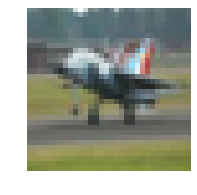

In [36]:
img = x()
x().show()

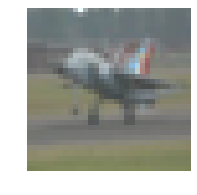

In [37]:
img.logit_px = contrast(img.logit_px, 0.5)
img.show()

In [38]:
from IPython.core.debugger import set_trace

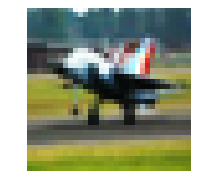

In [39]:
x().lighting(contrast, 2).show()

## Decorator and composition

We are interested in composing the transform functions so as to apply them all at once. We will try to feed a list of transforms to our pipeline for it to apply all of them.

Applying a function to our transforms before calling them in Python is easiest if we use a decorator. You can find more about decorators here.

Function decorators: wrappers to existing functions, to add new functionality to existing functions

In [40]:
def get_text(name):
    return "lorem ipsum, {0} dolor sit amet".format(name)

def p_decorate(func):
    def func_wrapper(name):
        return "<p>{0}</p>".format(func(name))
    return func_wrapper

get_text = p_decorate(get_text)

print(get_text("John"))

<p>lorem ipsum, John dolor sit amet</p>


In [41]:
# using decorator:
def p_decorate(func):
    def func_wrapper(name):
        return "<p>{0}</p>".format(func(name))
    return func_wrapper

def div_decorate(func):
    def func_wrapper(name):
        return "<div>{0}</div>".format(func(name))
    return func_wrapper
@p_decorate
def get_text(name):
    return "lorem ipsum, {0} dolor sit amet".format(name)
@p_decorate
def get_another_text(name):
    return "YO, {0} IS DOPE".format(name)

print (get_text("John"))
print(get_another_text("John"))

@div_decorate
@p_decorate
def get_another_text2(name):
    return "YO, {0} IS DOPE".format(name)
print(get_another_text2('John'))

<p>lorem ipsum, John dolor sit amet</p>
<p>YO, John IS DOPE</p>
<div><p>YO, John IS DOPE</p></div>


In [42]:
# PythonDecorators/my_decorator.py
class my_decorator(object):

    def __init__(self, f):
        print("inside my_decorator.__init__()")
        self.f = f
#         f() # Prove that function definition has completed

    def __call__(self, *args,**kwargs):
        print("inside my_decorator.__call__()")
        print(args)
        print(kwargs)
        self.f(*args,**kwargs)

@my_decorator
def aFunction(x,y=1):
    print("inside aFunction() with arg "+str(x)+ " and kwarg " + str(y))

print("Finished decorating aFunction()")

inside my_decorator.__init__()
Finished decorating aFunction()


In [43]:
aFunction(3)

inside my_decorator.__call__()
(3,)
{}
inside aFunction() with arg 3 and kwarg 1


In [44]:
aFunction(3,4)

inside my_decorator.__call__()
(3, 4)
{}
inside aFunction() with arg 3 and kwarg 4


In [45]:
aFunction(x=3,y=4)

inside my_decorator.__call__()
()
{'x': 3, 'y': 4}
inside aFunction() with arg 3 and kwarg 4


## Transform class

In [46]:
class Transform():
    _wrap=None
    def __init__(self, func): self.func=func
    def __call__(self, x, *args, **kwargs):
        if self._wrap:
            # if _wrap is 'lighting', it will call x.lighting, which essentially do func(logit(x),*args, **kwargs) 
            # and return the Image obj itself
            return getattr(x, self._wrap)(self.func, *args, **kwargs)
        else:          
            return self.func(x, *args, **kwargs)
    
class TfmLighting(Transform): _wrap='lighting'

In [47]:
@TfmLighting
def brightness(x, change): 
    # the change to be added to x for brightness should be between 0 and 1, as it will be transformed using logit
    # Note that x in here is already logit
    return x.add_(scipy.special.logit(change))
@TfmLighting
def contrast(x, scale): 
    return x.mul_(scale)

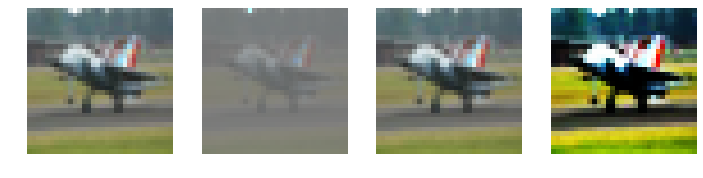

In [48]:

_,axes = plt.subplots(1,4, figsize=(12,3))

x().show(axes[0])
contrast(x(), 0.2).show(axes[1])
contrast(x(), 1).show(axes[2])
contrast(x(), 4).show(axes[3])

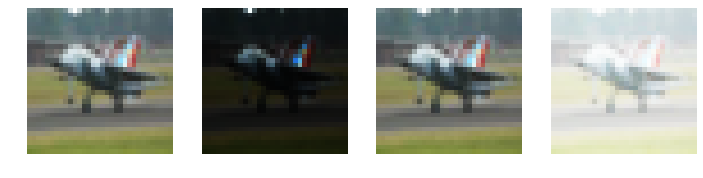

In [49]:
_,axes = plt.subplots(1,4, figsize=(12,3))

x().show(axes[0])
brightness(x(), 0.1).show(axes[1])
brightness(x(), 0.5).show(axes[2])
brightness(x(), 0.9).show(axes[3])

In [50]:
def brightness_contrast(x, scale_contrast, change_brightness):
    return brightness(contrast(x, scale=scale_contrast), change=change_brightness)

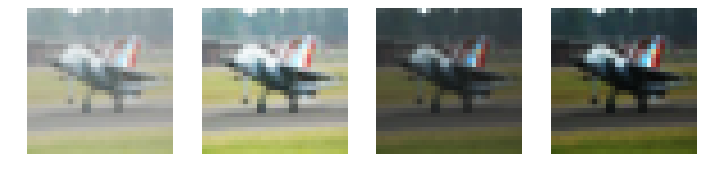

In [51]:
_,axes = plt.subplots(1,4, figsize=(12,3))

brightness_contrast(x(), 0.75, 0.7).show(axes[0]) # less contrast,  brighter
brightness_contrast(x(), 1.3,  0.7).show(axes[1])# more contrast, brighter
brightness_contrast(x(), 0.75,0.3).show(axes[2]) # less contrast, dimmer
brightness_contrast(x(), 1.3, 0.3).show(axes[3]) # more contrast, dimmer

## Random lighting

Next, we will make our previous transforms random since we are interested in automatizing the transforms pipeline. We will achieve this by making our parameters stochastic with a specific distribution: uniform for brightness and log_uniform for contrast.

We will use a *uniform* distribution for brightness change since its domain is the real numbers and the impact varies linearly with the scale. For contrast we use *log_uniform* for two reasons. First, contrast scale has a domain of [0, inf]. Second, the impact of the scale in the transformation is non-linear (i.e. 0.5 is as extreme as 2.0, 0.2 is as extreme as 5). The log_uniform function is appropriate because it has the same domain and correctly represents the non-linearity of the transform, P(0.5) = P(2).

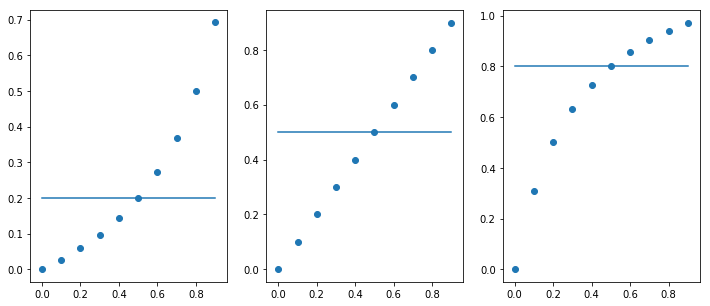

In [52]:
# brightness impact varies linearly with scale
def logit(x):  return scipy.special.logit(x)
def sigmoid(x): return 1 / (1+np.e**(-x))
fig,axes = plt.subplots(1,3,figsize=(12,5))
pixel=0.2
brightness=[i/10 for i in range(10)]
pixel_r = [sigmoid(logit(pixel) + logit(i)) for i in brightness]
axes[0].plot(brightness,[pixel]*len(brightness))
axes[0].scatter(brightness,pixel_r)

pixel=0.5
brightness=[i/10 for i in range(10)]
pixel_r = [sigmoid(logit(pixel) + logit(i)) for i in brightness]
axes[1].plot(brightness,[pixel]*len(brightness))
axes[1].scatter(brightness,pixel_r)

pixel=0.8
brightness=[i/10 for i in range(10)]
pixel_r = [sigmoid(logit(pixel) + logit(i)) for i in brightness]
axes[2].plot(brightness,[pixel]*len(brightness))
axes[2].scatter(brightness,pixel_r)

Dim pixels are insensitive to small brightness change, but very sensitive to large brightness change

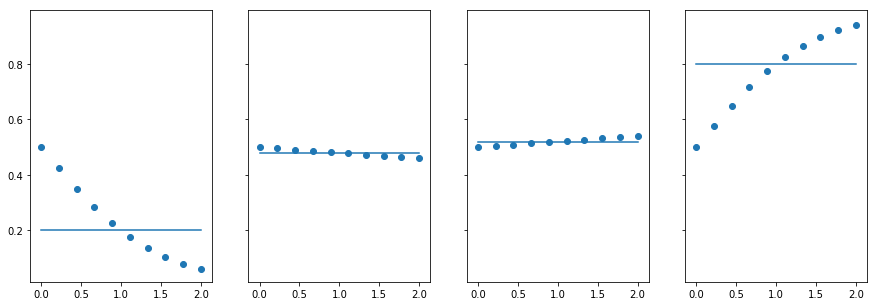

In [53]:
# contrast scales affect pixel differently

fig,axes = plt.subplots(1,4,figsize=(15,5),sharey=True)

pixel=0.2
contrast_scale=np.linspace(0,2,10)
pixel_r = [sigmoid(logit(pixel)*i) for i in contrast_scale]
axes[0].plot(contrast_scale,[pixel]*len(contrast_scale))
axes[0].scatter(contrast_scale,pixel_r)

pixel=0.48
contrast_scale=np.linspace(0,2,10)
pixel_r = [sigmoid(logit(pixel)*i) for i in contrast_scale]
axes[1].plot(contrast_scale,[pixel]*len(contrast_scale))
axes[1].scatter(contrast_scale,pixel_r)

pixel=0.52
contrast_scale=np.linspace(0,2,10)
pixel_r = [sigmoid(logit(pixel)*i) for i in contrast_scale]
axes[2].plot(contrast_scale,[pixel]*len(contrast_scale))
axes[2].scatter(contrast_scale,pixel_r)

pixel=0.8
contrast_scale=np.linspace(0,2,10)
pixel_r = [sigmoid(logit(pixel)*i) for i in contrast_scale]
axes[3].plot(contrast_scale,[pixel]*len(contrast_scale))
axes[3].scatter(contrast_scale,pixel_r)

Dim pixel gets dimmer when scale increases. ~0.5 pixel does not change much

In [54]:
#export
FloatOrTensor = Union[float,Tensor]
BoolOrTensor = Union[bool,Tensor]
def uniform(low:Number, high:Number, size:List[int]=None)->FloatOrTensor:
    "Draw 1 or shape=`size` random floats from uniform dist: min=`low`, max=`high`"
    return random.uniform(low,high) if size is None else torch.FloatTensor(*listify(size)).uniform_(low,high)

def log_uniform(low, high, size=None)->FloatOrTensor:
    "Draw 1 or shape=`size` random floats from uniform dist: min=log(`low`), max=log(`high`)"
    res = uniform(log(low), log(high), size)
    return exp(res) if size is None else res.exp_()

def rand_bool(p:float, size=None)->BoolOrTensor: 
    "Draw 1 or shape=`size` random booleans (True occuring probability p)"
    return uniform(0,1,size)<p

In [55]:
scipy.stats.gmean([log_uniform(0.5,2.0) for _ in range(1000)])

0.9791281747306562

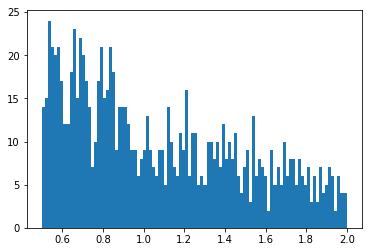

In [56]:
# log uniform distribution
log_u = [log_uniform(0.5,2.0) for _ in range(1000)]
plt.hist(log_u,bins=100);

In [57]:
#export
import inspect
from copy import copy,deepcopy

def get_default_args(func:Callable):
    return {k: v.default
            for k, v in inspect.signature(func).parameters.items()
            if v.default is not inspect.Parameter.empty}

ListOrItem = Union[Collection[Any],int,float,str]
OptListOrItem = Optional[ListOrItem]
def listify(p:OptListOrItem=None, q:OptListOrItem=None):
    "Makes `p` same length as `q`"
    # duplicate single-item list p q times
    if p is None: p=[]
    elif not isinstance(p, Iterable): p=[p]
    n = q if type(q)==int else len(p) if q is None else len(q)
    if len(p)==1: p = p * n
    assert len(p)==n, f'List len mismatch ({len(p)} vs {n})'
    return list(p)

In [58]:
# def compose(funcs):
#     # funcs is list of partial functions. Execute this list of functions in order
#     # compose acts as a wrapper for multiple PARTIAL functions in funcs list
#     def _inner(x, *args, **kwargs):
#         for f in listify(funcs): x = f(x, *args, **kwargs)
#         return x
#     return _inner if funcs else None

In [59]:
listify(2)
listify((2),3)
listify(2,[3,4])
# listify([2,3],3)

[2]

[2, 2, 2]

[2, 2]

Old transform class
```
class Transform():
    _wrap=None
    def __init__(self, func): self.func=func
    def __call__(self, x, *args, **kwargs):
        if self._wrap:
            # if _wrap is 'lighting', it will call x.lighting, which essentially do func(logit(x),*args, **kwargs) 
            # and return the Image obj itself
            return getattr(x, self._wrap)(self.func, *args, **kwargs)
        else:          
            return self.func(x, *args, **kwargs)
    
class TfmLighting(Transform): _wrap='lighting'
```


In [60]:
class Transform():
    "Utility class for adding probability and wrapping support to transform funcs"
    _wrap=None
    order=0
    def __init__(self, func:Callable, order:Optional[int]=None)->None:
        "Create a transform for `func` and assign it an priority `order`, attach to Image class"
        if order is not None: self.order=order
        self.func=func
        functools.update_wrapper(self, self.func)
        self.func.__annotations__['return'] = Image
        self.params = copy(func.__annotations__)
        self.def_args = get_default_args(func)
        setattr(Image, func.__name__,
                lambda x, *args, **kwargs: self.calc(x, *args, **kwargs))
        
    def __call__(self, *args:Any, p:float=1., is_random:bool=True, **kwargs:Any)->Image:
        "Calc now if `args` passed; else create a transform called prob `p` if `random`"
#         set_trace()
        if args: return self.calc(*args, **kwargs)
        else: return RandTransform(self, kwargs=kwargs, is_random=is_random, p=p)
        
    def calc(self, x:Image, *args:Any, **kwargs:Any)->Image:
        "Apply this transform to image `x`, wrapping it if necessary"
        if self._wrap: return getattr(x, self._wrap)(self.func, *args, **kwargs)
        else:          return self.func(x, *args, **kwargs)

    @property
    def name(self)->str: return self.__class__.__name__
    
    def __repr__(self)->str: return f'{self.name} ({self.func.__name__})'

class TfmLighting(Transform): order,_wrap = 8,'lighting' #order = 8,_wrap='lighting'

In [61]:
@dataclass
class RandTransform():
    "Wraps `Transform` to add randomized execution"
    tfm:Transform
    kwargs:dict
    p:int=1.0
    resolved:dict = field(default_factory=dict)
    do_run:bool = True
    is_random:bool = True
    def __post_init__(self): functools.update_wrapper(self, self.tfm)
    
    def resolve(self)->None:
        "Bind any random variables needed tfm calc"
#         set_trace()
        if not self.is_random:
            self.resolved = {**self.tfm.def_args, **self.kwargs}
            return

        self.resolved = {}
        # for each param passed to tfm...
        for k,v in self.kwargs.items():
            # ...if it's annotated, call that fn...
            if k in self.tfm.params:
                rand_func = self.tfm.params[k]
                self.resolved[k] = rand_func(*listify(v))
            # ...otherwise use the value directly
            else: self.resolved[k] = v
        # use defaults for any args not filled in yet
        for k,v in self.tfm.def_args.items():
            if k not in self.resolved: self.resolved[k]=v
        # anything left over must be callable without params
        for k,v in self.tfm.params.items():
            if k not in self.resolved and k!='return': self.resolved[k]=v()

        self.do_run = rand_bool(self.p)

    @property
    def order(self)->int: return self.tfm.order

    def __call__(self, x:Image, *args, **kwargs)->Image:
        "Randomly execute our tfm on `x`"
        return self.tfm(x, *args, **{**self.resolved, **kwargs}) if self.do_run else x

In [62]:
#export
@TfmLighting
def brightness(x, change:uniform): 
    "`change` brightness of image `x`"
    return x.add_(scipy.special.logit(change))

@TfmLighting
def contrast(x, scale:log_uniform): 
    "`scale` contrast of image `x`"
    return x.mul_(scale)

In [63]:
x = lambda: train_ds[1][0] # to avoid transform the tensor permanently
x()

Image (torch.Size([3, 32, 32]))

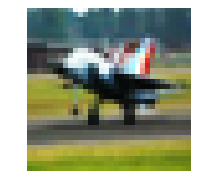

In [64]:
x().contrast(scale=2).show() #???

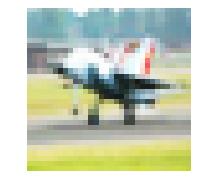

In [65]:
x().contrast(scale=2).brightness(0.8).show()

In [66]:
tfm = contrast(scale=(0.3,3))
tfm.resolve() # generate random var, depends on what type of transformation it is
tfm,tfm.resolved,tfm.do_run

(RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.3, 3)}, p=1.0, resolved={'scale': 0.32393314489198255}, do_run=True, is_random=True),
 {'scale': 0.32393314489198255},
 True)

{'scale': 1.5499807749525654}

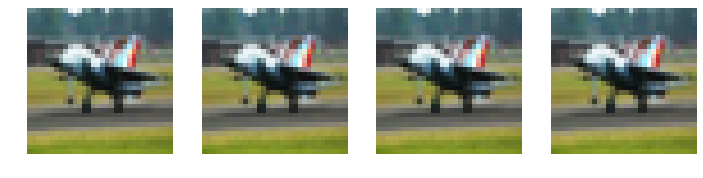

In [67]:
# all the same
tfm.resolve()
tfm.resolved
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: tfm(x()).show(ax)

{'scale': 0.9047953787606849}
{'scale': 0.7254999377956005}
{'scale': 0.5660292909552934}
{'scale': 0.7594158426158606}


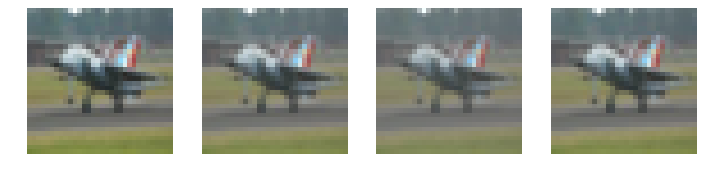

In [68]:
# all different
tfm = contrast(scale=(0.3,3))

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes:
    tfm.resolve()
    print(tfm.resolved)
    tfm(x()).show(ax)

{'scale': 2}

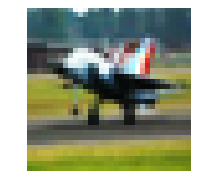

In [69]:
#fix scale
tfm = contrast(scale=2, is_random=False)
tfm.resolve()
tfm.resolved
tfm(x()).show()

# Composition

In [70]:
TfmList=Union[Transform, Collection[Transform]]
def resolve_tfms(tfms:TfmList):
    "Resolve every tfm in `tfms`"
    for f in listify(tfms): f.resolve()

def apply_tfms(tfms:TfmList, x:Image, do_resolve:bool=True):
    "Apply all the `tfms` to `x`, if `do_resolve` refresh all the random args"
    if not tfms: return x
    tfms = listify(tfms)
    if do_resolve: resolve_tfms(tfms)
    x = x.clone()
    for tfm in tfms: x = tfm(x)
    return x

In [71]:
x= train_ds[1][0]

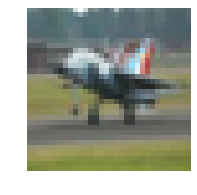

In [72]:
#original
apply_tfms([],x).show()

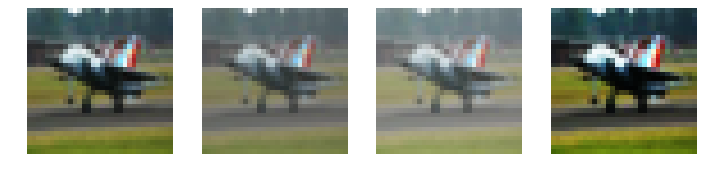

In [73]:
tfms = [contrast(scale=(0.3,3.0), p=0.9),
        brightness(change=(0.35,0.65), p=0.9)]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: apply_tfms(tfms,x).show(ax)

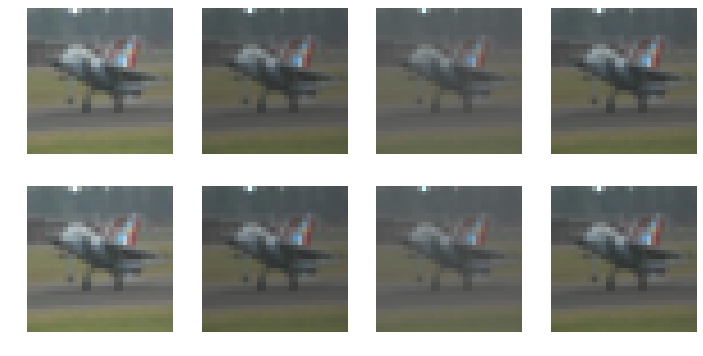

In [74]:
_,axes = plt.subplots(2,4, figsize=(12,6))
for i in range(4):
    apply_tfms(tfms,x).show(axes[0,i])
    apply_tfms(tfms,x,do_resolve=False).show(axes[1,i])

## DatasetTfm

Old dataset class
```
@dataclass
class DatasetTfm(Dataset):
    "Applies `tfm` to `ds`"
    ds: Dataset
    tfm: Callable = None

    def __len__(self): return len(self.ds)

    def __getitem__(self,idx:int):
        "Apply `tfm` to `x` and return `(x[idx],y[idx])`"
        x,y = self.ds[idx]
        if self.tfm is not None: x = self.tfm(x)
        return x,y
```

In [75]:
#export
class DatasetTfm(Dataset):
    "A `Dataset` that applies a list of transforms to every item drawn"
    def __init__(self, ds:Dataset, tfms:TfmList=None, **kwargs:Any):
        "this dataset will apply `tfms` to `ds`"
        self.ds,self.tfms,self.kwargs = ds,tfms,kwargs
        
    def __len__(self)->int: return len(self.ds)
    
    def __getitem__(self,idx:int)->Tuple[Image,Any]:
        "returns tfms(x),y"
        x,y = self.ds[idx]
        return apply_tfms(self.tfms, x, **self.kwargs), y
    
    def __getattr__(self,k): 
        "passthrough access to wrapped dataset attributes"
        return getattr(self.ds, k)

In [76]:
import nb_001b
nb_001b.DatasetTfm = DatasetTfm

bs=64

In [77]:
#export
ItemsList = Collection[Union[Tensor,ItemBase,'ItemsList',float,int]]
def to_data(b:ItemsList):
    "Recursively maps lists of items to their wrapped data"
    if is_listy(b): return [to_data(o) for o in b]
    return b.data if isinstance(b,ItemBase) else b

def data_collate(batch:ItemsList)->Tensor:
    "Convert `batch` items to tensor data"
    return torch.utils.data.dataloader.default_collate(to_data(batch))

Old DeviceDataLoader
```
@dataclass
class DeviceDataLoader():
    "`DataLoader` that ensures batches from `dl` are on `device`"
    dl: DataLoader
    device: torch.device

    def __len__(self) -> int: return len(self.dl)
    def proc_batch(self,b:Tensors): return to_device(b, self.device)

    def __iter__(self)->Tensors:
        "Ensure batches from `dl` are on `device` as we iterate"
        self.gen = map(self.proc_batch, self.dl)
        return iter(self.gen)

    @classmethod
    def create(cls, *args, device:torch.device=default_device, **kwargs): return cls(DataLoader(*args, **kwargs), device=device)
```

In [78]:
@dataclass
class DeviceDataLoader():
    "DataLoader that ensures items in each batch are tensor on specified device"
    dl: DataLoader
    device: torch.device
    def __post_init__(self)->None: self.dl.collate_fn=data_collate

    def __len__(self)->int: return len(self.dl)
    def __getattr__(self,k:str)->Any: return getattr(self.dl, k)
    def proc_batch(self,b:ItemsList)->Tensor: return to_device(b, self.device)

    def __iter__(self):
        self.gen = map(self.proc_batch, self.dl)
        return iter(self.gen)

    @classmethod
    def create(cls, *args, device=default_device, **kwargs)->'DeviceDataLoader':
        "Creates `DataLoader` and make sure its data is always on `device`"
        return cls(DataLoader(*args, **kwargs), device=device)
    
nb_001b.DeviceDataLoader = DeviceDataLoader

Current DataBunch class
```
@dataclass
class DataBunch():
    "Bind `train_dl`, `valid_dl` to `device`"
    train_dl:DataLoader
    valid_dl:DataLoader
    device:torch.device=None

    @classmethod
    def create(cls, train_ds:Dataset, valid_ds:Dataset, bs:int=64,
               train_tfm:Tfms=None, valid_tfm:Tfms=None, device:torch.device=None, **kwargs):
        return cls(DeviceDataLoader.create(DatasetTfm(train_ds, train_tfm), bs,   shuffle=True,  device=device, **kwargs),
                   DeviceDataLoader.create(DatasetTfm(valid_ds, valid_tfm), bs*2, shuffle=False, device=device, **kwargs),
                   device=device)
```

In [79]:
data = DataBunch.create(train_ds, valid_ds, bs=bs, num_workers=4)
len(data.train_dl), len(data.valid_dl), data.train_dl.dataset.c

(157, 16, 2)

In [80]:
#export
def show_image_batch(dl:DataLoader, classes:Collection[str], 
                     rows:Optional[int]=None, figsize:Tuple[int,int]=(12,15))->None:
    "Show a batch of images from `dl` titled according to `classes`"
    x,y = next(iter(dl))
    if rows is None: rows = int(math.sqrt(len(x)))
    show_images(x[:rows*rows],y[:rows*rows],rows, classes)

def show_images(x:Collection[Image],y:int,rows:int, classes:Collection[str], figsize:Tuple[int,int]=(9,9))->None:
    "Plot images (`x[i]`) from `x` titled according to classes[y[i]]"
    fig, axs = plt.subplots(rows,rows,figsize=figsize)
    for i, ax in enumerate(axs.flatten()):
        show_image(x[i], ax)
        ax.set_title(classes[y[i]])
    plt.tight_layout()

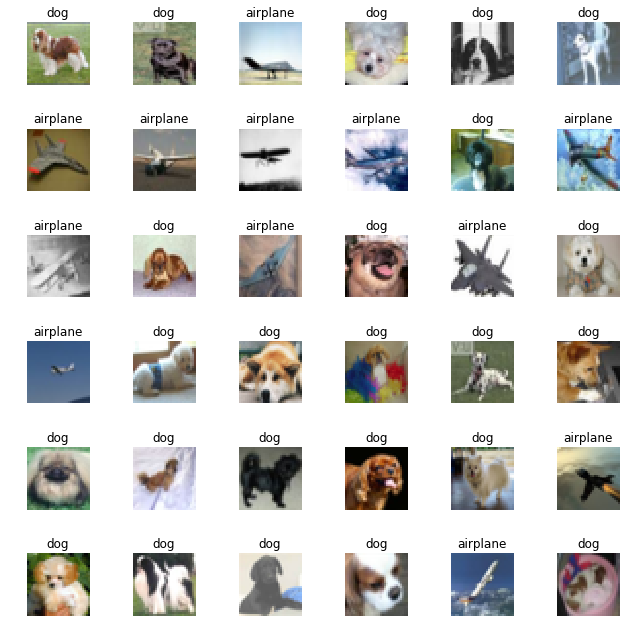

In [90]:
# show_image_batch(data.train_dl, train_ds.classes, 6)

In [81]:
tfms = [contrast(scale=(0.3,3.0), p=0.9),
        brightness(change=(0.35,0.65), p=0.9)]

In [82]:
data = DataBunch.create(train_ds, valid_ds, bs=bs, train_tfm=tfms)

# Affine

We will now add affine transforms that operate on the coordinates instead of pixels like the lighting transforms we just saw. An [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) is a function "(...) between affine spaces which preserves points, straight lines and planes." 

# Details

Our implementation first creates a grid of coordinates for the original image. The grid is normalized to a [-1, 1] range with (-1, -1) representing the top left corner, (1, 1) the bottom right corner and (0, 0) the center. Next, we build an affine matrix representing our desired transform and we multiply it by our original grid coordinates. The result will be a set of x, y coordinates which references where in the input image will each of the pixels in the output image be mapped. It has a size of w \* h \* 2 since it needs two coordinates for each of the h * w pixels of the output image. 

This is clearest if we see it graphically. We will build an affine matrix of the following form:

`[[a, b, e],
 [c, d, f]]`


with which we will transform each pair of x, y coordinates in our original grid into our transformation grid:


`[[a, b],       [[x],       [[e],       [[x'],
  [c, d]]   x    [y]]    +   [f]]    =   [y']]`   

So after the transform we will get a new grid with which to map our input image into our output image. This will be our **map of where from exactly does our transformation source each pixel in the output image**.

**Enter problems**

Affine transforms face two problems that must be solved independently:
1. **The interpolation problem**: The result of our transformation gives us float coordinates, and we need to decide, for each (i,j), how to assign these coordinates to pixels in the input image.
2. **The missing pixel problem**: The result of our transformation may have coordinates which exceed the [-1, 1] range of our original grid and thus fall outside of our original grid.

**Solutions to problems**

1.  **The interpolation problem**: We will perform a [bilinear interpolation](https://en.wikipedia.org/wiki/Bilinear_interpolation). This takes an average of the values of the pixels corresponding to the four points in the grid surrounding the result of our transformation, with weights depending on how close we are to each of those points. 
2. **The missing pixel problem**: For these values we need padding, and we face a few options:

    1. Adding zeros on the side (so the pixels that fall out will be black)
    2. Replacing them by the value at the border
    3. Mirroring the content of the picture on the other side (reflect padding).
    
    
### Transformation Method

**Zoom**

Zoom changes the focus of the image according to a scale. If a scale of >1 is applied, grid pixels will be mapped to coordinates that are more central than the pixel's coordinates (closer to 0,0) while if a scale of <1 is applied, grid pixels will be mapped to more perispheric coordinates (closer to the borders) in the input image.

We can also translate our transform to zoom into a non-centrical area of the image. For this we use $col_c$ which displaces the x axis and $row_c$ which displaces the y axis.

_Parameters_

1. **Scale** How much do we want to zoom in or out to our image.

    Domain:  Real numbers
        
2. **Col_pct** How much do we want to displace our zoom along the x axis.

    Domain: Real numbers between 0 and 1
    
    
3. **Row_pct** How much do we want to displace our zoom along the y axis.

    Domain: Real numbers between 0 and 1
    

<u>Affine matrix</u>

`[[1/scale, 0,       col_c],
  [0,       1/scale, row_c]]`


**Rotate**

Rotate shifts the image around its center in a given angle theta. The rotation is counterclockwise if theta is positive and clockwise if theta is negative. If you are curious about the derivation of the rotation matrix you can find it [here](https://matthew-brett.github.io/teaching/rotation_2d.html).

_Parameters_

1. **Degrees** By which angle do we want to rotate our image.

    Domain: Real numbers
        
<u>Affine matrix</u>

`[[cos(theta), -sin(theta), 0],
  [sin(theta),  cos(theta), 0]]`

In [83]:
#export
def grid_sample_nearest(input:TensorImage, coords:FlowField, padding_mode:str='zeros')->TensorImage:
    "Grab pixels in `coords` from `input`. sample with nearest neighbor mode, pad with zeros by default"
    if padding_mode=='border': coords.clamp(-1,1)
    bs,ch,h,w = input.size()
    sz = tensor([w,h]).float()[None,None]
    coords.add_(1).mul_(sz/2)
    coords = coords[0].round_().long()
    if padding_mode=='zeros':
        mask = (coords[...,0] < 0) + (coords[...,1] < 0) + (coords[...,0] >= w) + (coords[...,1] >= h)
        mask.clamp_(0,1)
    coords[...,0].clamp_(0,w-1)
    coords[...,1].clamp_(0,h-1)
    result = input[...,coords[...,1],coords[...,0]]
    if padding_mode=='zeros': result[...,mask] = result[...,mask].zero_()
    return result

In [84]:
#export
def grid_sample(x:TensorImage, coords:FlowField, mode:str='bilinear', padding_mode:str='reflect')->TensorImage:
    "Grab pixels in `coords` from `input` sampling by `mode`. pad is reflect or zeros."
    if padding_mode=='reflect': padding_mode='reflection'
    #if mode=='nearest': return grid_sample_nearest(x[None], coords, padding_mode)[0]
    return F.grid_sample(x[None], coords, mode=mode, padding_mode=padding_mode)[0]

def affine_grid(size:TensorImageSize)->FlowField:
    '''
    Create a (1,h,w,2) contains coord (x,y) on an evenly separated grid from -1 to 1. See example c_temp below
    '''
    size = ((1,)+size)
    N, C, H, W = size
    grid = FloatTensor(N, H, W, 2)
    linear_points = torch.linspace(-1, 1, W) if W > 1 else tensor([-1])
    grid[:, :, :, 0] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, :, 0])
    linear_points = torch.linspace(-1, 1, H) if H > 1 else tensor([-1])
    grid[:, :, :, 1] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, :, 1])
    return grid

def affine_mult(c:FlowField, m:AffineMatrix)->FlowField:
    if m is None: return c
    size = c.size()
    c = c.view(-1,2)
    c = torch.addmm(m[:2,2], c,  m[:2,:2].t()) 
    return c.view(size)

In [85]:
def rotate(degrees):
    angle = degrees * math.pi / 180 # to radian
    return [[cos(angle), -sin(angle), 0.],
            [sin(angle),  cos(angle), 0.],
            [0.        ,  0.        , 1.]]

In [86]:
def xi(): return train_ds[1][0]
x = xi().data

In [87]:
x.shape
x

torch.Size([3, 32, 32])

tensor([[[0.4431, 0.4392, 0.3961,  ..., 0.3176, 0.3216, 0.3333],
         [0.3569, 0.3412, 0.3490,  ..., 0.3059, 0.3098, 0.3529],
         [0.3373, 0.3294, 0.3412,  ..., 0.3059, 0.3020, 0.3216],
         ...,
         [0.5961, 0.5882, 0.5922,  ..., 0.4510, 0.4510, 0.4471],
         [0.4941, 0.4980, 0.4980,  ..., 0.4667, 0.4627, 0.4627],
         [0.4392, 0.4549, 0.4706,  ..., 0.5059, 0.4941, 0.4784]],

        [[0.5255, 0.5176, 0.4745,  ..., 0.3922, 0.4000, 0.4118],
         [0.4588, 0.4431, 0.4431,  ..., 0.3804, 0.3843, 0.4275],
         [0.4353, 0.4314, 0.4392,  ..., 0.3765, 0.3765, 0.3922],
         ...,
         [0.5843, 0.5765, 0.5843,  ..., 0.4902, 0.4941, 0.4902],
         [0.5490, 0.5490, 0.5451,  ..., 0.5098, 0.5059, 0.5059],
         [0.5098, 0.5255, 0.5333,  ..., 0.5569, 0.5451, 0.5294]],

        [[0.5412, 0.5333, 0.4941,  ..., 0.4118, 0.4157, 0.4314],
         [0.4745, 0.4549, 0.4627,  ..., 0.4039, 0.4078, 0.4549],
         [0.4588, 0.4510, 0.4627,  ..., 0.4078, 0.4078, 0.

In [88]:
c_temp = affine_grid((1,5,5))
c_temp.shape
c_temp[0,...]

torch.Size([1, 5, 5, 2])

tensor([[[-1.0000, -1.0000],
         [-0.5000, -1.0000],
         [ 0.0000, -1.0000],
         [ 0.5000, -1.0000],
         [ 1.0000, -1.0000]],

        [[-1.0000, -0.5000],
         [-0.5000, -0.5000],
         [ 0.0000, -0.5000],
         [ 0.5000, -0.5000],
         [ 1.0000, -0.5000]],

        [[-1.0000,  0.0000],
         [-0.5000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.5000,  0.0000],
         [ 1.0000,  0.0000]],

        [[-1.0000,  0.5000],
         [-0.5000,  0.5000],
         [ 0.0000,  0.5000],
         [ 0.5000,  0.5000],
         [ 1.0000,  0.5000]],

        [[-1.0000,  1.0000],
         [-0.5000,  1.0000],
         [ 0.0000,  1.0000],
         [ 0.5000,  1.0000],
         [ 1.0000,  1.0000]]])

In [89]:
c = affine_grid(x.shape)
c.shape

torch.Size([1, 32, 32, 2])

In [90]:
m = rotate(30)
m = x.new_tensor(m)
m

tensor([[ 0.8660, -0.5000,  0.0000],
        [ 0.5000,  0.8660,  0.0000],
        [ 0.0000,  0.0000,  1.0000]])

In [91]:
c_temp = affine_mult(c_temp,m)

In [92]:
c_temp

tensor([[[[-0.3660, -1.3660],
          [ 0.0670, -1.1160],
          [ 0.5000, -0.8660],
          [ 0.9330, -0.6160],
          [ 1.3660, -0.3660]],

         [[-0.6160, -0.9330],
          [-0.1830, -0.6830],
          [ 0.2500, -0.4330],
          [ 0.6830, -0.1830],
          [ 1.1160,  0.0670]],

         [[-0.8660, -0.5000],
          [-0.4330, -0.2500],
          [ 0.0000,  0.0000],
          [ 0.4330,  0.2500],
          [ 0.8660,  0.5000]],

         [[-1.1160, -0.0670],
          [-0.6830,  0.1830],
          [-0.2500,  0.4330],
          [ 0.1830,  0.6830],
          [ 0.6160,  0.9330]],

         [[-1.3660,  0.3660],
          [-0.9330,  0.6160],
          [-0.5000,  0.8660],
          [-0.0670,  1.1160],
          [ 0.3660,  1.3660]]]])

In [93]:
c = affine_mult(c,m)

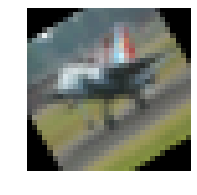

In [94]:
img2 = grid_sample(x, c, padding_mode='zeros')
show_image(img2);

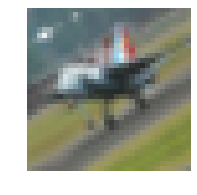

In [95]:
img2 = grid_sample(x, c)
show_image(img2);

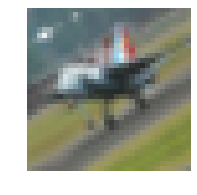

In [96]:
xi().affine(rotate, 30).show()

# Affine transform

In [97]:
#export
class TfmAffine(Transform): 
    "Wraps affine tfm funcs"
    order,_wrap = 5,'affine'
class TfmPixel(Transform): 
    "Wraps pixel tfm funcs"
    order,_wrap = 10,'pixel'

@TfmAffine
def rotate(degrees:uniform):
    "Affine func that rotates the image"
    angle = degrees * math.pi / 180
    return [[cos(angle), -sin(angle), 0.],
            [sin(angle),  cos(angle), 0.],
            [0.        ,  0.        , 1.]]

def get_zoom_mat(sw:float, sh:float, c:float, r:float)->AffineMatrix:
    "`sw`,`sh` scale width,height - `c`,`r` focus col,row"
    return [[sw, 0,  c],
            [0, sh,  r],
            [0,  0, 1.]]

@TfmAffine
def zoom(scale:uniform=1.0, row_pct:uniform=0.5, col_pct:uniform=0.5):
    "Zoom image by `scale`. `row_pct`,`col_pct` select focal point of zoom"
    s = 1-1/scale
    col_c = s * (2*col_pct - 1)
    row_c = s * (2*row_pct - 1)
    return get_zoom_mat(1/scale, 1/scale, col_c, row_c)

@TfmAffine
def squish(scale:uniform=1.0, row_pct:uniform=0.5, col_pct:uniform=0.5):
    "Squish image by `scale`. `row_pct`,`col_pct` select focal point of zoom"
    if scale <= 1: 
        col_c = (1-scale) * (2*col_pct - 1)
        return get_zoom_mat(scale, 1, col_c, 0.)
    else:          
        row_c = (1-1/scale) * (2*row_pct - 1)
        return get_zoom_mat(1, 1/scale, 0., row_c)

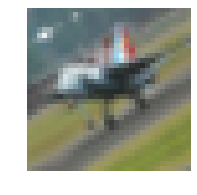

In [98]:
rotate(xi(), 30).show()

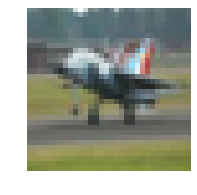

In [102]:
xi().show()

## zoom

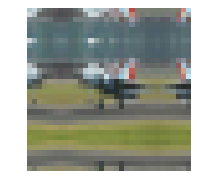

In [99]:
zoom(xi(), 0.6).show()

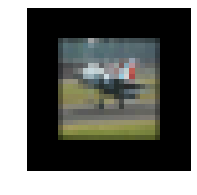

In [100]:
zoom(xi(), 0.6).set_sample(padding_mode='zeros').show()
# set_sample is to set parameteres for F.grid_sample function

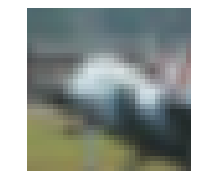

In [104]:
zoom(xi(), 2, 0.2, 0.2).show()

## squish

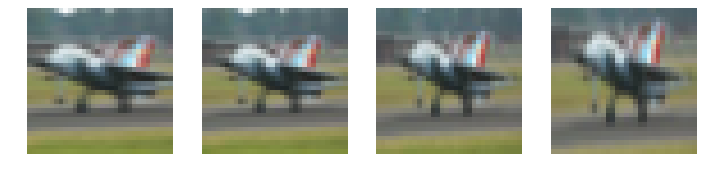

In [105]:

scales = [0.75,0.9,1.1,1.33]

_,axes = plt.subplots(1,4, figsize=(12,3))
for i, ax in enumerate(axes): squish(xi(), scales[i]).show(ax)

## order of transformation

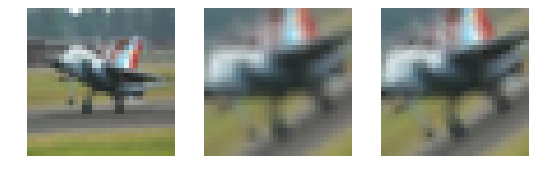

In [106]:
img2 = rotate(xi(), 30).refresh()
img2 = zoom(img2, 1.6)
_,axes=plt.subplots(1,3,figsize=(9,3))
xi().show(axes[0]) #original
img2.show(axes[1]) # rotate->refresh->zoom. More blurry! Why?
zoom(rotate(xi(), 30), 1.6).show(axes[2]) #rotate->zoom

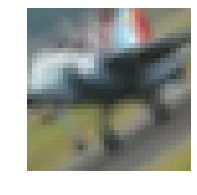

In [107]:
# zoom then rotate
rotate(zoom(xi(),1.6),30).show()

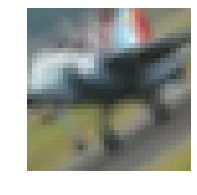

In [108]:
# rotate then zoom
zoom(rotate(xi(), 30), 1.6).show()

## resize

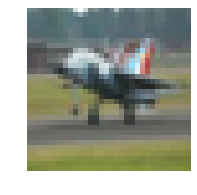

In [113]:
# original
xi().show()

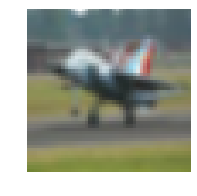

In [117]:
xi().resize(48).show()

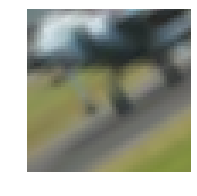

In [119]:
# resize to higher resolution -> zoom in -> rotate
img2 = zoom(xi().resize(48), 1.6, 0.8, 0.2)
rotate(img2, 30).show()

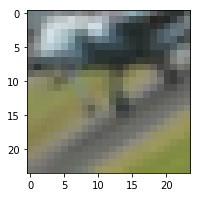

In [121]:
#  resize to lower resolution -> zoom in -> rotate
img2 = zoom(xi().resize(24), 1.6, 0.8, 0.2)
rotate(img2, 30).show(hide_axis=False)

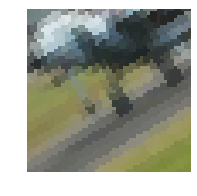

In [122]:
img2 = zoom(xi().resize(48), 1.6, 0.8, 0.2)
rotate(img2, 30).set_sample(mode='nearest').show()

# Random affine


As we did with the Lighting transform, we now want to build randomness into our pipeline so we can increase the automatization of the transform process.

We will use a uniform distribution for both our transforms since their impact is linear and their domain is the real numbers.

**Apply all transforms**

We will make all transforms try to do as little calculations as possible.

We do only one affine transformation by
- multiplying all the affine matrices of the transforms
- then we apply to the coords any non-affine transformation we might want (jitter, elastic distorsion). 
- Next, we crop the coordinates we want to keep (by doing it before the interpolation, we don't need to compute pixel values that won't be used afterwards.)
- Finally we perform the interpolation and we apply all the transforms that operate pixelwise (brightness, contrast).

In [133]:
tfm = rotate(degrees=(-45,45.), p=0.75); tfm
tfm.resolve(); tfm

RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-45, 45.0)}, p=0.75, resolved={}, do_run=True, is_random=True)

RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-45, 45.0)}, p=0.75, resolved={'degrees': 42.33212919730664}, do_run=False, is_random=True)

In [125]:
tfm.resolve(); tfm

RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-45, 45.0)}, p=0.75, resolved={'degrees': 38.415441623069285}, do_run=True, is_random=True)

In [134]:
x = xi()

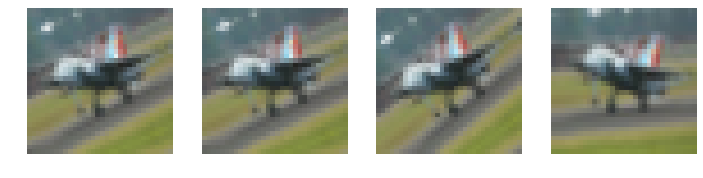

In [140]:
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: apply_tfms(tfm, x).show(ax)

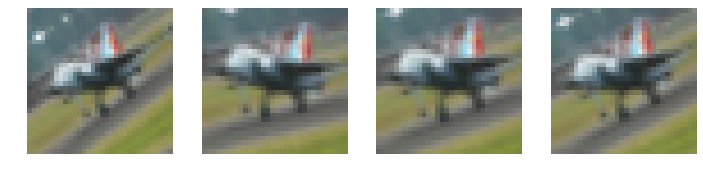

In [143]:
# combine rotate and zoom
tfms = [rotate(degrees=(-45,45.), p=0.75),
        zoom(scale=(0.5,2.0), p=0.75)]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: apply_tfms(tfms,x).show(ax)

Old apply_tfms func
```
TfmList=Union[Transform, Collection[Transform]]
def resolve_tfms(tfms:TfmList):
    "Resolve every tfm in `tfms`"
    for f in listify(tfms): f.resolve()

def apply_tfms(tfms:TfmList, x:Image, do_resolve:bool=True):
    "Apply all the `tfms` to `x`, if `do_resolve` refresh all the random args"
    if not tfms: return x
    tfms = listify(tfms)
    if do_resolve: resolve_tfms(tfms)
    x = x.clone()
    for tfm in tfms: x = tfm(x)
    return x
```

In [145]:
#export
def apply_tfms(tfms:TfmList, x:TensorImage, do_resolve:bool=True, 
               xtra:Optional[Dict[Transform,dict]]=None, size:TensorImageSize=None, **kwargs:Any)->TensorImage:
    "Apply `tfms` to x, resize to `size`. `do_resolve` rebind random params. `xtra` custom args for a tfm. kwargs for grid_sample"
    if not (tfms or size): return x
    if not xtra: xtra={}
    tfms = sorted(listify(tfms), key=lambda o: o.tfm.order) # sort order of transformation
    if do_resolve: resolve_tfms(tfms)
    x = x.clone()
    if kwargs: x.set_sample(**kwargs)
    if size: x.resize(size)
    for tfm in tfms:
        if tfm.tfm in xtra: x = tfm(x, **xtra[tfm.tfm])
        else:               x = tfm(x)
    return x

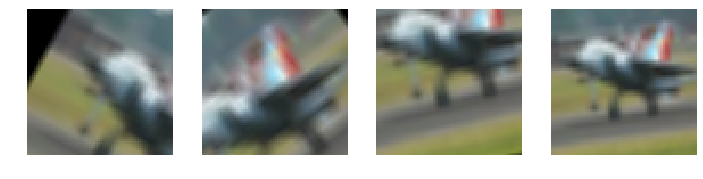

In [147]:
tfms = [rotate(degrees=(-45,45.), p=0.75),
        zoom(scale=(1.0,2.0), row_pct=(0,1.), col_pct=(0,1.))]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: apply_tfms(tfms,x, padding_mode='zeros', size=64).show(ax)
# rotate + zoom with zeros padding and resize to (64,64)

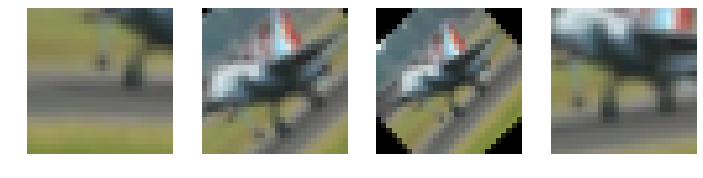

In [148]:
tfms = [rotate(degrees=(-45,45.), p=0.75),
        zoom(scale=(1.0,2.0), row_pct=(0,1.), col_pct=(0,1.))]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: apply_tfms(tfms,x, padding_mode='zeros', size=28).show(ax)

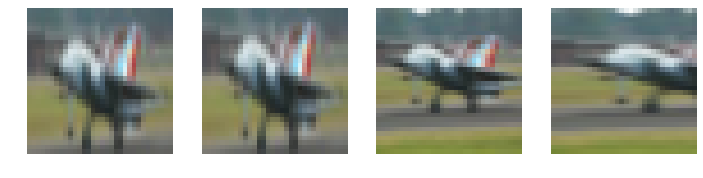

In [156]:
tfms = [squish(scale=(0.5,2), row_pct=(0,1.), col_pct=(0,1.))]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: apply_tfms(tfms,x).show(ax)

# Coord and pixel

## Jitter / flip

The last two transforms we will use are **jitter** and **flip**. 

**Jitter**

Jitter is a transform which adds a random value to each of the pixels to make them somewhat different than the original ones. In our implementation we first get a random number between (-1, 1) and we multiply it by a constant M which scales it.

_Parameters_

1. **Magnitude** How much random noise do we want to add to each of the pixels in our image.

    Domain: Real numbers between 0 and 1.
    
**Flip**

Flip is a transform that reflects the image on a given axis.

_Parameters_

1. **P** Probability of applying the transformation to an input.

    Domain: Real numbers between 0 and 1.

In [163]:
#export
class TfmCoord(Transform): order,_wrap = 4,'coord'

@TfmCoord
def jitter(c, size, magnitude:uniform):
    return c.add_((torch.rand_like(c)-0.5)*magnitude*2)

@TfmPixel
def flip_lr(x): return x.flip(2)

RandTransform(tfm=TfmCoord (jitter), kwargs={'magnitude': (0, 0.1)}, p=1.0, resolved={'magnitude': 0.04943279683373704}, do_run=True, is_random=True)
RandTransform(tfm=TfmCoord (jitter), kwargs={'magnitude': (0, 0.1)}, p=1.0, resolved={'magnitude': 0.0455019530734955}, do_run=True, is_random=True)
RandTransform(tfm=TfmCoord (jitter), kwargs={'magnitude': (0, 0.1)}, p=1.0, resolved={'magnitude': 0.002988633535816221}, do_run=True, is_random=True)
RandTransform(tfm=TfmCoord (jitter), kwargs={'magnitude': (0, 0.1)}, p=1.0, resolved={'magnitude': 0.06164369809378584}, do_run=True, is_random=True)


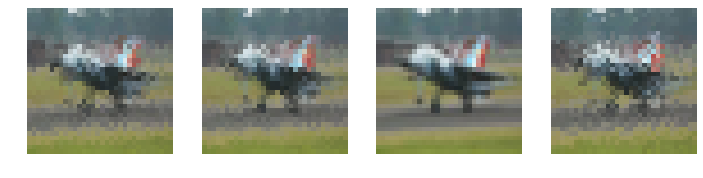

In [165]:
# jitter
tfm = jitter(magnitude=(0,0.1))

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes:
    tfm.resolve()
    print(tfm)
    tfm(xi()).show(ax)

RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True)
RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=False, is_random=True)
RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=False, is_random=True)
RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True)


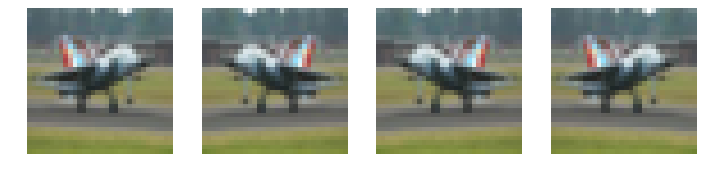

In [168]:
# flip
tfm = flip_lr(p=0.5)

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes:
    tfm.resolve()
    print(tfm)
    tfm(xi()).show(ax)

## Crop/pad

**Crop**

Crop is a transform that cuts a series of pixels from an image. It does this by removing rows and columns from the input image.

_Parameters_

1. **Size** What is the target size of each side in pixels. If only one number *s* is specified, image is made square with dimensions *s* \* *s*.

    Domain: Positive integers.
    
2. **Row_pct** Determines where to cut our image vertically on the bottom and top (which rows are left out). If <0.5, more rows will be cut in the top than in the bottom and viceversa (varies linearly).

    Domain: Real numbers between 0 and 1.
    
3. **Col_pct** Determines where to cut our image horizontally on the left and right (which columns are left out). If <0.5, more rows will be cut in the left than in the right and viceversa (varies linearly).

    Domain: Real numbers between 0 and 1.
    
Our three parameters are related with the following equations:

1. output_rows = [**row_pct***(input_rows-**size**):**size**+**row_pct***(input_rows-**size**)]

2. output_cols = [**col_pct***(input_cols-**size**):**size**+**col_pct***(input_cols-**size**)]

**Pad**


Pads each of the four borders of our image with a certain amount of pixels. Can pad with reflection (reflects border pixels to fill new pixels) or zero (adds black pixels). 

_Parameters_

1. **Padding** Amount of pixels to add to each border. [More details](https://pytorch.org/docs/stable/nn.html#torch.nn.functional.pad)

    Domain: Positive integers.
    
2. **Mode** How to fill new pixels. For more detail see the Pytorch subfunctions for padding.

    Domain: 
    - Reflect (default): reflects opposite pixels to fill new pixels. [More details](https://pytorch.org/docs/stable/nn.html#torch.nn.ReflectionPad2d)
    - Constant: adds pixels with specified value (default is 0, black pixels) [More details](https://pytorch.org/docs/stable/nn.html#torch.nn.ConstantPad2d)
    - Replicate: replicates border row or column pixels to fill new pixels [More details](https://pytorch.org/docs/stable/nn.html#torch.nn.ReplicationPad2d)
    
    
***On using padding and crop***

A nice way to use these two functions is to combine them into one transform. We can add padding to the image and then crop some of it out. This way, we can create a new image to augment our training set without losing image information by cropping. Furthermore, this can be done in several ways (modifying the amount and type of padding and the crop style) so it gives us great flexibility to add images to our training set. You can find an example of this in the code below.

In [169]:
[(o.__name__,o.order) for o in
    sorted((Transform,TfmAffine,TfmCoord,TfmLighting,TfmPixel),key=attrgetter('order'))]

[('Transform', 0),
 ('TfmCoord', 4),
 ('TfmAffine', 5),
 ('TfmLighting', 8),
 ('TfmPixel', 10)]

In [170]:
#export
@partial(TfmPixel, order=-10)
def pad(x, padding, mode='reflect'):
    "Pad `x` with `padding` pixels. `mode` fills in space ('reflect','constant','replicate',etc)"
    return F.pad(x[None], (padding,)*4, mode=mode)[0]

@TfmPixel
def crop(x, size, row_pct:uniform=0.5, col_pct:uniform=0.5):
    "Crop `x` to `size` pixels. `row_pct`,`col_pct` select focal point of crop"
    size = listify(size,2)
    rows,cols = size
    row = int((x.size(1)-rows+1) * row_pct)
    col = int((x.size(2)-cols+1) * col_pct)
    return x[:, row:row+rows, col:col+cols].contiguous()

torch.Size([3, 40, 40])

torch.Size([3, 38, 38])

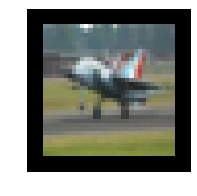

In [176]:
#padding
pad(xi(), 4, 'constant').shape
pad(xi(), 3, 'constant').shape
pad(xi(), 4, 'constant').show()

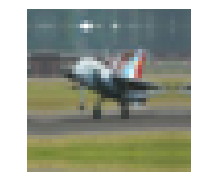

In [178]:
pad(xi(), 4, 'reflect').show()

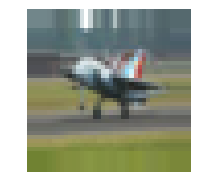

In [179]:
pad(xi(), 4, 'replicate').show()

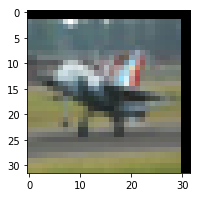

In [180]:
#crop (from pad so easier to see the crop based on the black outlines)
crop(pad(xi(), 4, 'constant'), 32, 0.25, 0.75).show(hide_axis=False)

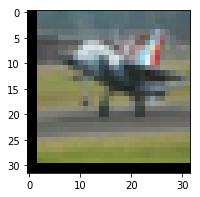

In [184]:
crop(pad(xi(), 4, 'constant'), 32, 0.75, 0.25).show(hide_axis=False)

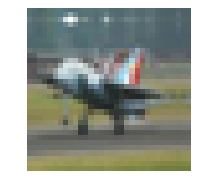

In [181]:
crop(pad(xi(), 4), 32, 0.25, 0.75).show()

# Combine all

In [185]:
tfms = [flip_lr(p=0.5),
        pad(padding=4, mode='constant'),
        crop(size=32, row_pct=(0,1.), col_pct=(0,1.))]

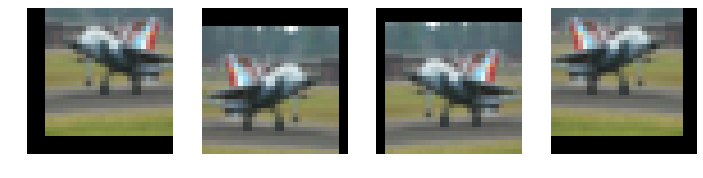

In [186]:
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: apply_tfms(tfms, x).show(ax)

In [210]:
tfms = [
    flip_lr(p=0.5),
    contrast(scale=(0.5,2.0)),
    brightness(change=(0.3,0.7)),
    rotate(degrees=(-45,45.), p=0.5),
    zoom(scale=(0.5,1.2), p=0.8) # note that it is zoomed out and padding mode is reflect, hence the weird kaieidoscope in some pics
]

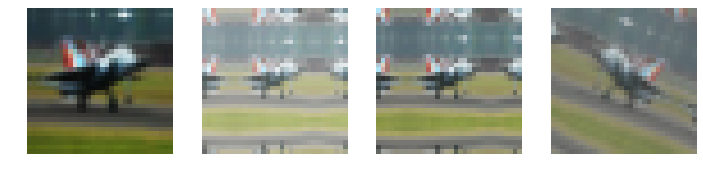

In [211]:
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: apply_tfms(tfms, x).show(ax)

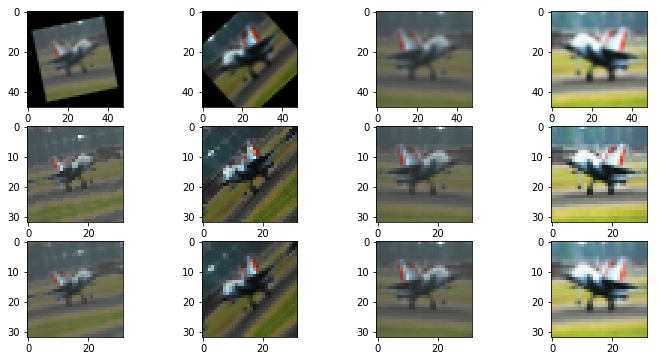

In [230]:
_,axes = plt.subplots(3,4, figsize=(12,6))

for i in range(4):
    apply_tfms(tfms, x, padding_mode='zeros', size=48).show(axes[0][i], hide_axis=False) # first row, zeros padding results in black outlines
    apply_tfms(tfms, x, mode='nearest', do_resolve=False).show(axes[1][i], hide_axis=False) # same transformation with nearest mode
    apply_tfms(tfms, x, mode='bilinear', do_resolve=False).show(axes[2][i], hide_axis=False)

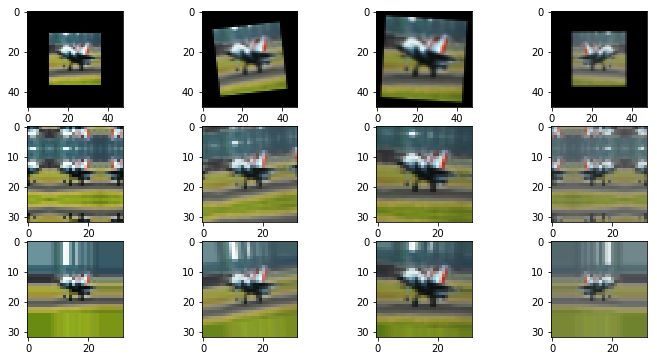

In [231]:
_,axes = plt.subplots(3,4, figsize=(12,6))

for i in range(4):
    apply_tfms(tfms, x, padding_mode='zeros', size=48).show(axes[0][i], hide_axis=False) # first row, zeros padding results in black outlines
    apply_tfms(tfms, x, padding_mode='reflection', do_resolve=False).show(axes[1][i], hide_axis=False)
    apply_tfms(tfms, x, padding_mode='border', do_resolve=False).show(axes[2][i], hide_axis=False)

## RandomResizedCrop (Torchvision version)

In [233]:
#export
def compute_zs_mat(sz:TensorImageSize, scale:float, squish:float, 
                   invert:bool, row_pct:float, col_pct:float)->AffineMatrix:
    "Utility routine to compute zoom/squish matrix"
    orig_ratio = math.sqrt(sz[2]/sz[1])
    for s,r,i in zip(scale,squish, invert):
        s,r = math.sqrt(s),math.sqrt(r)
        if s * r <= 1 and s / r <= 1: #Test if we are completely inside the picture
            w,h = (s/r, s*r) if i else (s*r,s/r)
            w /= orig_ratio
            h *= orig_ratio
            col_c = (1-w) * (2*col_pct - 1)
            row_c = (1-h) * (2*row_pct - 1)
            return get_zoom_mat(w, h, col_c, row_c)
        
    #Fallback, hack to emulate a center crop without cropping anything yet.
    if orig_ratio > 1: return get_zoom_mat(1/orig_ratio**2, 1, 0, 0.)
    else:              return get_zoom_mat(1, orig_ratio**2, 0, 0.)

@TfmCoord
def zoom_squish(c, size, scale:uniform=1.0, squish:uniform=1.0, invert:rand_bool=False, 
                row_pct:uniform=0.5, col_pct:uniform=0.5):
    #This is intended for scale, squish and invert to be of size 10 (or whatever) so that the transform
    #can try a few zoom/squishes before falling back to center crop (like torchvision.RandomResizedCrop)
    m = compute_zs_mat(size, scale, squish, invert, row_pct, col_pct)
    return affine_mult(c, FloatTensor(m))

In [234]:
rrc = zoom_squish(scale=(0.25,1.0,10), squish=(0.5,1.0,10), invert=(0.5,10),
                                  row_pct=(0,1.), col_pct=(0,1.))

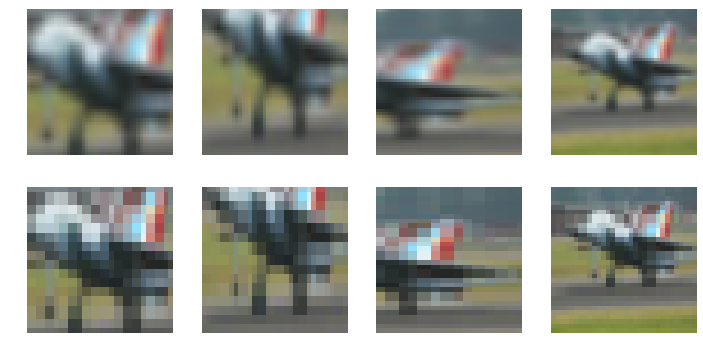

In [241]:
_,axes = plt.subplots(2,4, figsize=(12,6))
for i in range(4):
    apply_tfms(rrc, x, size=48).show(axes[0][i])
    apply_tfms(rrc, x, do_resolve=False, mode='nearest').show(axes[1][i])

# Old note

In [19]:
# explaining compose function
def show_stuff(x,k1=42,k2='yolo'):
    print(x)
    print(k1)
    print(k2)
def wrap(func): # passing in a partial function
    def inner(*args,**kwargs): # since func remember its fixed parameter, 
        #its wrapper, inner, will also get these fixed parameters
        func(*args,**kwargs)        
    return inner

func3 = partial(show_stuff,k2='YOLO BIATCH') # func3 already remember its fixed parameter here
wrap(func3)(3)

3
42
YOLO BIATCH


In [108]:
def func1(a,b,c:int,d='temp'):
    pass
get_default_args(func1)

{'d': 'temp'}

In [26]:
# #export
# import inspect
# from copy import copy,deepcopy

# def get_default_args(func):
#     return {k: v.default
#             for k, v in inspect.signature(func).parameters.items()
#             if v.default is not inspect.Parameter.empty}

# class Transform():
#     def __init__(self, func, p=1., **kwargs):
# #         set_trace()
#         # func is the lowest-level tfm function, i.e contrast. Not partial. Input parameters: x (tensor) and a constant (scale)
#         self.func,self.p,self.kw = func,p,kwargs #self.kw is a dict {tfm_param : (low,high)}, i,e {'scale':(0.3,5)}
#         self.def_args = get_default_args(func) # get tfm default param in dic {tfm_param: constant}, i.e {'scale':1}
#         self.params = copy(func.__annotations__)
#         # i.e for contrast, self.params should be  {'scale': <func to get random scale from log distribution b/t low and high>}
#         self.params.pop('return') 
#     @property
#     def name(self): return self.__class__.__name__ # a getter
    
#     def __repr__(self):
#         return f'{self.func.__name__}_tfm->{self.name}; {self.kw} (p={self.p})'

#     def resolve(self):
#         # either get a constant from random distribution or other use case?
#         self.resolved = {}
#         for k,v in self.params.items():
#             if k not in self.kw and k in self.def_args: 
#                 # if there is a default param for tfm but it's not specified in self.kw
#                 # TODO: use case for this? Probably when user wants a specific scale for transformation
#                 self.resolved[k] = self.def_args[k]
#             else: 
#                 # k in self.kw or k not in self.def_args
#                 # i.e, right hand side will be log_uniform(*(low,high))
#                 # self.resolved is {'scale': random constant between low and high}
#                 self.resolved[k] = v(*listify(self.kw[k]))
#         self.do_run = rand_bool(self.p) # boolean, True or False

#     def __call__(self, x, *args, **kwargs): # function call operator. Called when running tfm = Transform(...); tfm(...)
#         #execute the lowest-level transform function on x
#         #for contrast example, only kwargs are passed
#         return self.func(x, *args, **self.resolved, **kwargs) if self.do_run else x
    
#     def apply(self, tfms=None):
#         if tfms is None: 
#             # if there is no other tfm is passed, use self (the Transform class itself) as a function (__call__ wil be used)
#             tfms=self
#         # execute multiple low-level tfms using compose func. Return transformed x. resolve should be called first?
#         return compose(tfms)

# class TfmLighting(Transform):
#     def apply(self, tfms=None): 
#         # do the logit -> tfm func -> sigmoid for lighting
#         return apply_lighting(super().apply(tfms))